In [318]:
import src.paths

In [380]:
DATE = '2022-09-16'
COMB_Q = 8
COMB_MIN = 1
COMB_MAX = 100
CHANNEL = 159
CHANNEL_MIN = 0
CHANNEL_MAX = 239

In [381]:
def hilbert_comb(x, freqs, Q):
    l = []
    for w0 in freqs:
        b, a = scipy.signal.iirnotch(w0, Q, fs=1250)
        y = x - scipy.signal.filtfilt(b, a, x)
        y = scipy.signal.hilbert(y)
        l.append(y)
    return np.array(l).T

In [382]:
def resample_1250_250_Hz(df):
    idx = df.index[::5]
    t1 = pd.date_range(start=0, periods=len(df), freq='0.8ms')
    t2 = pd.date_range(start=0, periods=len(df) // 5, freq='4ms')
    df = df.set_index(t1).reindex(t2).interpolate(method='linear')
    return df.set_index(idx)

In [383]:
%%time
csd = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl')
csd = csd.loc[0:7200 - 1 / 1250, CHANNEL_MIN // 4:CHANNEL_MAX // 4] * 0.001

CPU times: user 646 ms, sys: 4.37 s, total: 5.01 s
Wall time: 34.1 s


In [384]:
%%time
spikes = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-spikes.pkl')
spikes = spikes.loc[0:7200 - 1 / 250, CHANNEL_MIN:CHANNEL_MAX]

CPU times: user 36.1 ms, sys: 805 ms, total: 841 ms
Wall time: 7.52 s


In [385]:
%%time
freq = pd.Series(range(COMB_MIN, COMB_MAX + 1), name='frequency')
signal = csd[CHANNEL // 4].values
hilbert = hilbert_comb(signal, freq, COMB_Q)
hilbert = pd.DataFrame(hilbert, index=csd.index, columns=freq)

CPU times: user 1min 12s, sys: 18.7 s, total: 1min 31s
Wall time: 1min 31s


In [386]:
%%time
csd = resample_1250_250_Hz(csd)
hilbert = resample_1250_250_Hz(hilbert)

CPU times: user 11.1 s, sys: 6.91 s, total: 18 s
Wall time: 18 s


---

In [361]:
START = 600
END = 610

In [367]:
lower = max(0, CHANNEL // 4 - 5)
upper = min(95, CHANNEL // 4 + 5)
raw = csd.loc[START:END - 1 / 250, lower:upper]

In [371]:
nyq = 250 / 2
b, a = scipy.signal.butter(N=5, Wn=[2 / nyq, 15 / nyq], btype='band')
y = scipy.signal.filtfilt(b, a, raw.values, axis=0)
filt = pd.DataFrame(y, index=raw.index, columns=raw.columns)

In [373]:
theta = hilbert.loc[START:END - 1 / 250, 2:15]
amp = theta.apply(np.abs)
phase = (theta.apply(np.angle) + np.pi) / (2 * np.pi)

In [376]:
spk = spikes.loc[START:END - 1 / 250]

In [379]:
csd.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61],
      dtype='int64', name='channel')

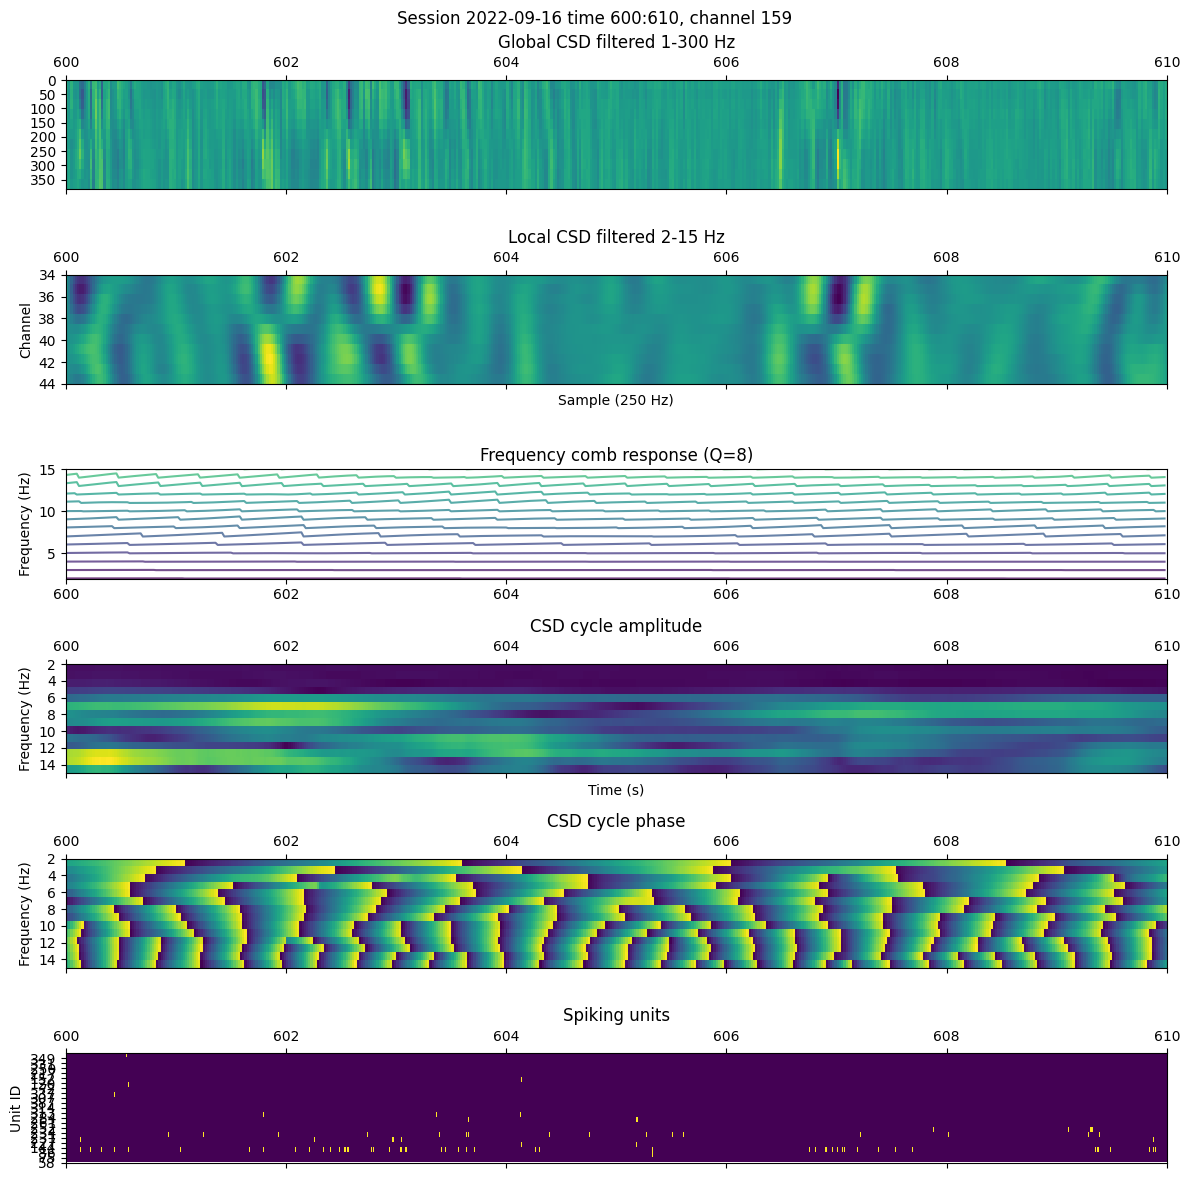

In [377]:
fig, ax = plt.subplots(6, 1, figsize=(12, 12))
plt.suptitle(f'Session {DATE} time {START}:{END}, channel {CHANNEL}')

plt.sca(ax[0])
plt.title(f'Global CSD filtered 1-300 Hz')
plt.gca().matshow(raw.T, extent=[START, END, 384, 0])
plt.axis('auto')

plt.sca(ax[1])
plt.title(f'Local CSD filtered 2-15 Hz')
plt.gca().matshow(filt.T, extent=[START, END, upper, lower])
plt.axis('auto')
plt.xlabel('Sample (250 Hz)')
plt.ylabel('Channel')

plt.sca(ax[2])
plt.title(f'Frequency comb response (Q={COMB_Q})')
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(2, 20)
for f in phi.columns:
    plt.plot(1.5 * amp[f] * phase[f] + f, alpha=0.75, color=cmap(norm(f)))
plt.ylabel('Frequency (Hz)')
plt.xlim([START, END])
plt.ylim([2, 15])

plt.sca(ax[3])
plt.title('CSD cycle amplitude')
plt.gca().matshow(amp.T, extent=[START, END, 15, 2])
plt.axis('auto')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.sca(ax[4])
plt.title('CSD cycle phase')
plt.gca().matshow(phase.T, extent=[START, END, 15, 2])
plt.axis('auto')
plt.ylabel('Frequency (Hz)')

plt.sca(ax[5])
plt.title(f'Spiking units')
plt.gca().matshow(spk.T, vmin=0, vmax=1, extent=[START, END, 0, len(spk.columns)])
plt.axis('auto')
plt.ylabel('Unit ID')
plt.yticks(range(len(spk.columns)), spk.columns)

plt.tight_layout()
plt.show()